In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from fuzzywuzzy import process
from sklearn.neighbors import NearestNeighbors

sns.set_theme()

In [2]:
movies_df = pd.read_csv('Data/movies.csv')
ratings_df = pd.read_csv('Data/ratings.csv') # Desperate attempts

### 1.1 - Movielens full - EDA

### a)

In [140]:
display(movies_df, ratings_df)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [141]:
display(
    movies_df.info(),
    ratings_df.info(),
    movies_df.describe().T,
    ratings_df.describe().T
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


None

None

,count,mean,std,min,25%,50%,75%,max
movieId,58098.0,111919.516197,59862.660956,1.0,72437.75,126549.0,161449.5,193886.0


,count,mean,std,min,25%,50%,75%,max
userId,27753444.0,1.419420e+05,8.170740e+04,1.0,71176.0,1.420220e+05,2.124590e+05,2.832280e+05
movieId,27753444.0,1.848800e+04,3.510263e+04,1.0,1097.0,2.716000e+03,7.150000e+03,1.938860e+05
rating,27753444.0,3.530445e+00,1.066353e+00,0.5,3.0,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,27753444.0,1.193122e+09,2.160482e+08,789652004.0,998605251.0,1.174256e+09,1.422744e+09,1.537945e+09


### b)

In [3]:
# Groupby movieId and get the size of each movie ratings list
ratings_per_movie = ratings_df.groupby('movieId').size()

ratings_per_movie = ratings_per_movie.sort_values(ascending=False)

top_10_ratings_movieId = ratings_per_movie[:10].index

# Manually pull out single movies (e.g dataframes with one row) in order maintain the correct order as
# no indicators exist for how to sort the list. Explicitly not using isin() because it returns a dataframe
# thats already sorted by index. I spent wayyy to long on this...
top_10_most_rated = [movies_df.loc[movies_df['movieId'] == i] for i in top_10_ratings_movieId]

# conCatenate all the individual dataframes into one. Meow!
top_10_most_rated = pd.concat(top_10_most_rated)

top_10_most_rated

C:\Users\Kevin\AppData\Local\Temp\ipykernel_908\3413104644.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_10_ratings_movieId = ratings_per_movie[:10].index


,movieId,title,genres
315,318,"Shawshank Redemption, The (1994)",Crime|Drama
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2487,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
523,527,Schindler's List (1993),Drama|War
108,110,Braveheart (1995),Action|Drama|War
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


##### Pretty expected tbh. Some great movies in the top 10

### c)

In [4]:
avr_ratings = ratings_df.groupby('movieId')['rating'].mean()

# Use the top_10_ratings_movieId to get the avr ratings for the top 10 movies
top_10_most_rated['average rating'] = avr_ratings[top_10_ratings_movieId].values
top_10_most_rated

,movieId,title,genres,average rating
315,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.424188
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.056585
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.173971
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.151412
2487,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.149695
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.120455
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.665034
523,527,Schindler's List (1993),Drama|War,4.257502
108,110,Braveheart (1995),Action|Drama|War,4.008481
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649


### d)

<AxesSubplot: xlabel='year'>

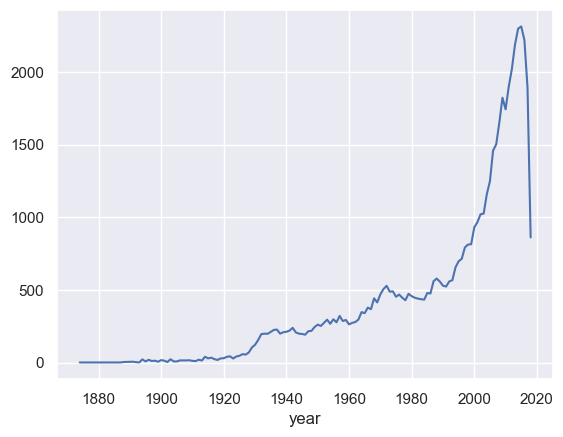

In [5]:
# extract the date in each movie title and create a new column for it
movies_df['year'] = movies_df['title'].str.extract("\((\d{4})\)", expand=False)

# Convert it to numeric so we can use mathematical operations
movies_df['year'] = pd.to_numeric(movies_df['year'])

# Get the movies per year
movies_per_year = movies_df.groupby('year').size()

sns.lineplot(x=movies_per_year.index, y=movies_per_year.values)

##### Interesting. innitially thought the dip was due to Corona, but apparely not (although that certainly didnt help things along either). What sorta doomsday event caused this? #MeToo?
###### Eh, probably just an anomaly in the data gathering process

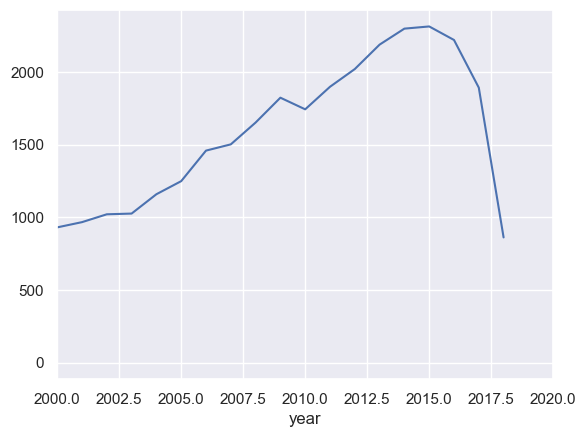

In [47]:
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values)
plt.xlim(2000, 2020)
plt.show()

### e)

##### Again, more unexpected stuff. What could've possibly caused that gap?

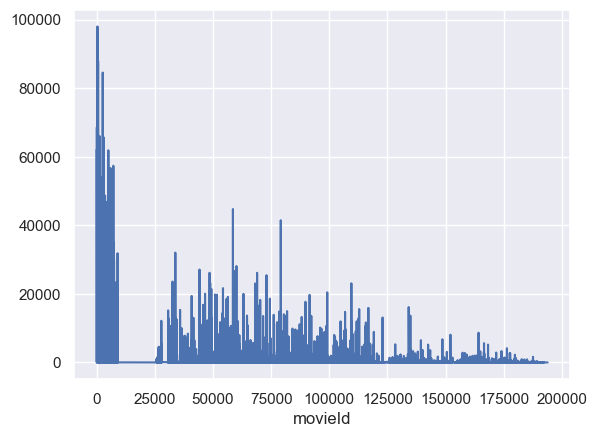

In [6]:
sns.lineplot(x=ratings_per_movie.index, y=ratings_per_movie);

### f)

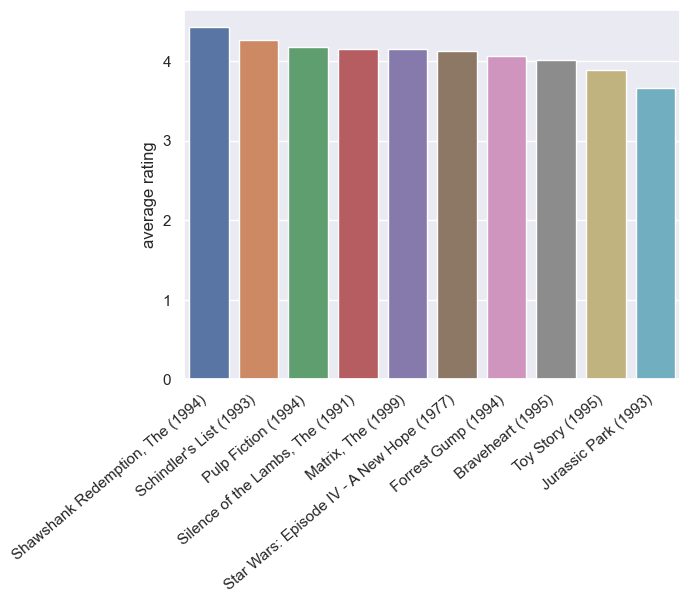

In [7]:
fig = sns.barplot(
    # sort by average rating, as that seems like a resonable thing to do
    data=top_10_most_rated.sort_values('average rating', ascending=False),
    x='title',
    y='average rating'
)

# Rotate to make labels fit
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, horizontalalignment='right');
fig.set(xlabel=None);

##### Misc plots - FIX

Text(0.5, 1.0, 'Movie Ratings by Decade')

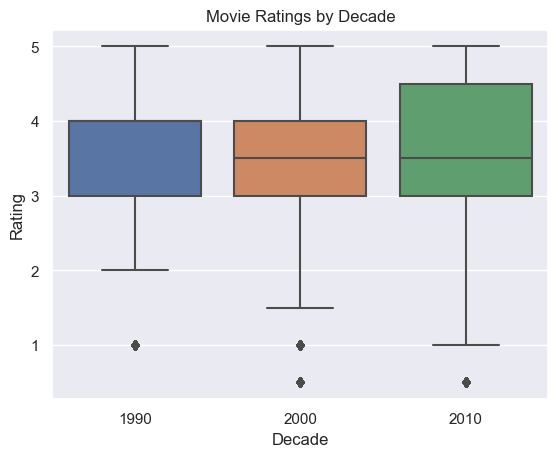

In [8]:
# Convert the timestamp column to datetime
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Create a new column for the decade of each rating
ratings_df['decade'] = ratings_df['timestamp'].dt.year // 10 * 10 # this single line Taken from ChatGPT

# Merge the ratings and movies DataFrames
ratings_and_movies = pd.merge(ratings_df, movies_df, on='movieId')

# Create a box plot of movie ratings by decade

sns.boxplot(x='decade', y='rating', data=ratings_and_movies)
plt.xlabel('Decade')
plt.ylabel('Rating')
plt.title('Movie Ratings by Decade')

In [9]:
# Consumes memory like crazy, dont have the patience of waiting for the GC to kick in.
del ratings_and_movies

# cleanup ratings_df after we've done all our plotting
ratings_df = ratings_df.drop(['timestamp', 'decade'], axis=1)

ratings_df

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


### 1.2

### Drop all ratings on movies without any genre specified

In [10]:
movies_no_genre = movies_df[movies_df['genres'] == '(no genres listed)']['movieId']
ratings_df = ratings_df.drop(ratings_df[ratings_df['movieId'].isin(movies_no_genre)].index)

ratings_df

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


##### Drop users with <10 or >200 ratings as having that few/many ratings is unresonable as it either doesn't<br> lead to any significant addition (prediction wise) or worse leads to a bias in the dataset

In [11]:
# groupby user to see how many ratings each user has
num_ratings_user = ratings_df.groupby('userId').size()

# get the userId (e.g index) of users with above 200 ratings
unsuitable_ratings_index = num_ratings_user[(num_ratings_user < 10) | (num_ratings_user > 200)].index

ratings_df = ratings_df.drop(ratings_df[ratings_df['userId'].isin(unsuitable_ratings_index)].index)

print(f'new size {len(ratings_df)}')

new size 10613225


##### Drop movies older than the 1960's

In [12]:
# Get the movie id movies older than the 1950's
movies_ids = movies_df[movies_df['year'] < 1950]['movieId']

ratings_df = ratings_df.drop(ratings_df[ratings_df['movieId'].isin(movies_ids)].index)

print(f'new size {len(ratings_df)}')

new size 10420336


##### Drop movies without a date

In [13]:
movies_no_date = movies_df[movies_df['year'].isnull()]['movieId']

ratings_df = ratings_df.drop(ratings_df[ratings_df['movieId'].isin(movies_no_date)].index)

ratings_df

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753429,283228,6377,5.0
27753430,283228,6874,4.0
27753441,283228,34405,4.5
27753442,283228,44761,4.5


##### Limit all movies to at most 1000 reviews

In [14]:
#ratings_df = ratings_df.groupby('movieId').head(1000)
#test = test.reset_index(drop=True)
ratings_df

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753429,283228,6377,5.0
27753430,283228,6874,4.0
27753441,283228,34405,4.5
27753442,283228,44761,4.5


In [19]:
# Calculate the mean rating score for each user
mean_user_rating = ratings_df.groupby('userId')['rating'].mean()

ratings_df = ratings_df[ratings_df['userId'].isin(mean_user_rating[mean_user_rating > 3.5].index)]
ratings_df

,userId,movieId,rating
16,2,170,3.5
17,2,849,3.5
18,2,1186,3.5
19,2,1235,3.0
20,2,1244,3.0
...,...,...,...
27753429,283228,6377,5.0
27753430,283228,6874,4.0
27753441,283228,34405,4.5
27753442,283228,44761,4.5


##### Drop 90% of all ratings in order to be able to actually process the data. Note that this shouldn't actually affect the quality of the dataset nor the predictions in any significant way due to the stochastic selection of rows to drop. This can roughly be seen by looking at a few key metrics.

In [58]:
ratings_mean = ratings_df['rating'].mean()
ratings_median = ratings_df['rating'].median()
ratings_std = ratings_df['rating'].std()

movie_ratings_mean = ratings_df.groupby('movieId')['rating'].mean().head()
movie_ratings_median = ratings_df.groupby('movieId')['rating'].median().head()
movie_ratings_std = ratings_df.groupby('movieId')['rating'].std().head()

print(f"{ratings_mean=} {ratings_median=} {ratings_std=}")
print(movie_ratings_mean.head(3), movie_ratings_median.head(3), movie_ratings_std.head(3))

ratings_mean=3.4573647867224855 ratings_median=4.0 ratings_std=1.2284039916162102
movieId
1    4.40
2    2.95
3    3.10
Name: rating, dtype: float64 movieId
1    4.50
2    3.25
3    3.00
Name: rating, dtype: float64 movieId
1    0.658281
2    1.553669
3    0.875595
Name: rating, dtype: float64


In [59]:
# drop_index = ratings_df.sample(frac=0.99, replace=False).index
# ratings_df = ratings_df.drop(drop_index)

In [60]:
ratings_mean = ratings_df['rating'].mean()
ratings_median = ratings_df['rating'].median()
ratings_std = ratings_df['rating'].std()

movie_ratings_mean = ratings_df.groupby('movieId')['rating'].mean().head()
movie_ratings_median = ratings_df.groupby('movieId')['rating'].median().head()
movie_ratings_std = ratings_df.groupby('movieId')['rating'].std().head()

print(f"{ratings_mean=} {ratings_median=} {ratings_std=}")
print(movie_ratings_mean.head(3), movie_ratings_median.head(3), movie_ratings_std.head(3))

ratings_mean=3.4573647867224855 ratings_median=4.0 ratings_std=1.2284039916162102
movieId
1    4.40
2    2.95
3    3.10
Name: rating, dtype: float64 movieId
1    4.50
2    3.25
3    3.00
Name: rating, dtype: float64 movieId
1    0.658281
2    1.553669
3    0.875595
Name: rating, dtype: float64


In [71]:
from scipy.sparse import csr_matrix


# create a sparse matrix directly from the data
#mat_movies_users = csr_matrix((test['rating'].values, (test['movieId'].values, test['userId'].values)))

# subtract 1 from the movieId and userId columns to convert them to zero-based indexing
# the resulting sparse matrix will have rows corresponding to movieId and columns corresponding to userId

movies = pd.Categorical(ratings_df['movieId'])
users = pd.Categorical(ratings_df['userId'])
mat_movies_users = csr_matrix((ratings_df['rating'], (movies.codes, users.codes)))



# truth = test.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# display(truth.values, mat_movies_users.indices)
# # np.array(truth.values) == np.array(mat_movies_users.data)

In [61]:
movies_users = ratings_df.pivot(index='movieId', columns='userId', values='rating').fillna(0)

mat_movies_users=csr_matrix(movies_users.values)

mat_movies_users.shape

(25212, 36337)

### 1.3

In [72]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)

In [73]:
knn_model.fit(mat_movies_users)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [75]:
# Recommender(movie_name) => List of Movies recommended

def recommender(movie_name, data,model, n_recommendations ):
    model.fit(data)
    idx=process.extractOne(movie_name, movies_df['title'])[2]
    print('Movie Selected: ',movies_df['title'][idx], 'Index: ',idx)
    print('Searching for recommendations.....')
    distances, indices=model.kneighbors(data[idx], n_neighbors=n_recommendations)
    for i in indices:
        print(movies_df['title'][i].where(i!=idx))
    
recommender('Toy Story', mat_movies_users, knn_model,20)


Movie Selected:  Toy Story (1995) Index:  0
Searching for recommendations.....
0                                                     NaN
758     Life Is Rosy (a.k.a. Life Is Beautiful) (Vie e...
256                                  Kiss of Death (1995)
351                               Flintstones, The (1994)
475                                 Judgment Night (1993)
635                                          Roula (1995)
2838      Handle with Care (a.k.a. Citizen's Band) (1977)
984                               Extreme Measures (1996)
1160                                  Mediterraneo (1991)
1107                                  Howling, The (1980)
719                             Heaven's Prisoners (1996)
581                                          Ghost (1990)
359     Wonderful, Horrible Life of Leni Riefenstahl, ...
31              Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
314                              Santa Clause, The (1994)
292                     Pyromaniac's Love Story, A 